# Lecture 20: Natural Language Processing II

CSCI 1360: Foundations for Informatics and Analytics

## Overview and Objectives

Last week, we introduced the concept of natural language processing, and in particular the "bag of words" model for representing and quantifying text for later analysis. In this lecture, we'll expand on those topics, including some additional preprocessing and text representation methods. By the end of this lecture, you should be able to

 - Implement several preprocessing techniques like stemming, stopwords, and minimum counts
 - Understand the concept of *feature vectors* in natural language processing
 - Compute inverse document frequencies to up or down-weight term frequencies

## Part 1: Feature Vectors

Preprocessing: ***why?***

From Lecture 19: *"Our goal in preprocessing is, in a sense, to **turn unstructured data into structured data**, or data that has a logical flow and format. CSV and JSON formats would be considered structured."*

"Bag of words" model: what does it give us?

**A way of representing documents.**

You're interested in blogs. Specifically, you're interested in how blogs link to each other. Do politically-liberal blogs tend to link to politically-conservative blogs, and vice versa? Or do they mostly link to themselves?

Imagine you have a list of a few hundred blogs. To get their political leanings, you'd need to analyze the blogs and see how similar they are.

To do that, you need some notion of *similarity*...

**We need to be able to represent the blogs as *feature vectors*.**

If you can come up with a quantitative representation of your "thing" of interest, then you can compare it to other instances of that thing.

The bag-of-words model is just one way of turning a document into a **feature vector** that can be used in analysis. By considering each blog to be a single document, you can therefore convert each blog to its own bag-of-words and compare them directly.

(in fact, this has actually been done)

![blogs](http://www-personal.umich.edu/~ladamic/img/politicalblogs.jpg)

http://waxy.org/2008/10/memeorandum_colors/

![featurevector](https://www.cs.princeton.edu/courses/archive/fall08/cos436/Duda/PR_Figs/F_space.gif)

If you have some data point $\vec{x}$ that is an $n$-dimensional vector (pictured above: a three-dimensional vector), each dimension is a single feature.

What does this correspond to with NumPy arrays?

Therefore, a bag-of-words model is just a way of **representing a document as a vector**, where the dimensions are word counts!

![wordvector](http://image.slidesharecdn.com/finalthesisslides1-140904051036-phpapp01/95/contextless-object-recognition-with-shapeenriched-sift-and-bags-of-features-14-638.jpg?cb=1409907136)

Pictured above are three separate documents, and the number of times each of the words appears is given by the height of the histogram bar.

Of course there are other ways of representing documents as vectors, but bag-of-words is the *easiest*.

## Part 2: Text Preprocessing

What is "preprocessing"?

Name some preprocessing techniques with text we've covered!

 - Lower case (or upper case) everything
 - Split into single words
 - Remove trailing whitespace (spaces, tabs, newlines)

There are a few more that can be very powerful.

To start, let's go back to the *Alice in Wonderland* example from the previous lecture, but this time, we'll add a few more books for comparison:

 - [*Pride and Prejudice*](https://www.gutenberg.org/ebooks/1342), by Jane Austen
 - [*Frankenstein*](https://www.gutenberg.org/ebooks/84), by Mary Shelley
 - [*Beowulf*](https://www.gutenberg.org/ebooks/16328), by Lesslie Hall
 - [*The Adventures of Sherlock Holmes*](https://www.gutenberg.org/ebooks/1661), by Sir Arthur Conan Doyle
 - [*The Adventures of Tom Sawyer*](https://www.gutenberg.org/ebooks/74), by Mark Twain
 - [*The Adventures of Huckleberry Finn*](https://www.gutenberg.org/ebooks/76), by Mark Twain

Hopefully this variety should give us a good idea what we're dealing with!

First, we'll read all the books' raw contents into a dictionary.

In [1]:
books = {}
files = ['alice.txt', 'pride.txt', 'frank.txt', 'bwulf.txt', 'holmes.txt', 'tom.txt', 'finn.txt']

for f in files:
    prefix = f.split(".")[0]
    try:
        with open(f, "r", encoding = "ISO-8859-1") as descriptor:
            books[prefix] = descriptor.read()
    except:
        print("File '{}' had an error!".format(f))
        books[prefix] = None

In [2]:
print(books.keys())

dict_keys(['alice', 'pride', 'frank', 'finn', 'tom', 'holmes', 'bwulf'])


Just like before, let's go ahead and lower case everything, strip out whitespace, then count all the words.

In [3]:
def preprocess(book):
    # First, lowercase everything.
    lower = book.lower()
    
    # Second, split into lines.
    lines = lower.split("\n")
    
    # Third, split each line into words.
    words = []
    for line in lines:
        words.extend(line.strip().split(" "))

    # That's it!
    return count(words)

In [4]:
from collections import defaultdict

def count(words):
    counts = defaultdict(int)
    for w in words:
        counts[w] += 1
    return counts

In [5]:
counts = {}
for k, v in books.items():
    counts[k] = preprocess(v)

Let's see how our basic preprocessing techniques from the last lecture worked out.

In [6]:
from collections import Counter

def print_results(counts):
    for key, bag_of_words in counts.items():
        word_counts = Counter(bag_of_words)
        mc_word, mc_count = word_counts.most_common(1)[0]
        print("'{}' has {} unique words, and the most common is '{}', occuring {} times."
              .format(key, len(bag_of_words.keys()), mc_word, mc_count))
print_results(counts)

'alice' has 5582 unique words, and the most common is 'the', occuring 1777 times.
'pride' has 13128 unique words, and the most common is 'the', occuring 4479 times.
'frank' has 11702 unique words, and the most common is 'the', occuring 4327 times.
'finn' has 13839 unique words, and the most common is 'and', occuring 6109 times.
'tom' has 13445 unique words, and the most common is 'the', occuring 3907 times.
'holmes' has 14544 unique words, and the most common is 'the', occuring 5704 times.
'bwulf' has 11024 unique words, and the most common is '', occuring 3497 times.


...clearly, we have some work to do.

Not only are the most common words among the most boring ("the"? "and"?), but there are occasions where the most common word isn't even a word, but rather a blank space. (How do you think that could happen?)

### Stop words

A great first step is to implement stop words. (I used [this list of 319 stop words](http://xpo6.com/list-of-english-stop-words/))

In [7]:
with open("stopwords.txt", "r") as f:
    lines = f.read().split("\n")
    stopwords = [w.strip() for w in lines]
print(stopwords[:5])

['a', 'about', 'above', 'across', 'after']


Now we'll augment our `preprocess` function to include stop word processing.

In [8]:
def preprocess_v2(book, stopwords):
    # First, lowercase everything.
    lower = book.lower()
    
    # Second, split into lines.
    lines = lower.split("\n")
    
    # Third, split each line into words.
    words = []
    for line in lines:
        tokens = line.strip().split(" ")
        
        # Check for stopwords.
        for t in tokens:
            if t in stopwords: continue
            words.append(t)

    # That's it!
    return count(words)

Now let's see what we have!

In [9]:
counts = {}
for k, v in books.items():
    counts[k] = preprocess_v2(v, stopwords)
    
print_results(counts)

'alice' has 5348 unique words, and the most common is '', occuring 1178 times.
'pride' has 12858 unique words, and the most common is '', occuring 2474 times.
'frank' has 11440 unique words, and the most common is '', occuring 3413 times.
'finn' has 13589 unique words, and the most common is '', occuring 2739 times.
'tom' has 13176 unique words, and the most common is '', occuring 2284 times.
'holmes' has 14278 unique words, and the most common is '', occuring 2750 times.
'bwulf' has 10781 unique words, and the most common is '', occuring 3497 times.


Well, this seems even worse! What could we try next?

### Minimum length

Pretty straightforward: cut out all the words under a certain length; say, 2.

In [10]:
def preprocess_v3(book, stopwords):
    # First, lowercase everything.
    lower = book.lower()
    
    # Second, split into lines.
    lines = lower.split("\n")
    
    # Third, split each line into words.
    words = []
    for line in lines:
        tokens = line.strip().split(" ")
        
        # Check for stopwords.
        for t in tokens:
            if t in stopwords or len(t) <= 2: continue
            words.append(t)

    # That's it!
    return count(words)

Maybe this will be better?

In [11]:
counts = {}
for k, v in books.items():
    counts[k] = preprocess_v3(v, stopwords)
    
print_results(counts)

'alice' has 5315 unique words, and the most common is 'said', occuring 421 times.
'pride' has 12777 unique words, and the most common is 'mr.', occuring 766 times.
'frank' has 11384 unique words, and the most common is 'me,', occuring 147 times.
'finn' has 13540 unique words, and the most common is 'got', occuring 603 times.
'tom' has 13122 unique words, and the most common is 'tom', occuring 461 times.
'holmes' has 14224 unique words, and the most common is 'said', occuring 448 times.
'bwulf' has 10669 unique words, and the most common is 'beowulf', occuring 112 times.


Ooh! Definite improvement! Though clearly, punctuation is getting in the way; it's featured in no fewer than two of our top words.

We spoke last time about how removing punctuation could be a little dangerous; what if the punctuation is inherent to the meaning of the word (i.e., a contraction)? 

Here, we'll compromise a little: we'll get the "easy" punctuation, like exclamation marks, periods, and commas, and leave the rest.

In [12]:
def preprocess_v4(book, stopwords):
    # First, lowercase everything.
    lower = book.lower()
    
    # Second, split into lines.
    lines = lower.split("\n")
    
    # Third, split each line into words.
    words = []
    for line in lines:
        tokens = line.strip().split(" ")
        
        # Check for stopwords.
        for t in tokens:

            # Cut off any end-of-sentence punctuation.
            if t.endswith(",") or t.endswith("!") or t.endswith(".") or \
                    t.endswith(":") or t.endswith(";") or t.endswith("?"):
                t = t[:-1]

            if t in stopwords or len(t) <= 2: continue
            words.append(t)

    # That's it!
    return count(words)

Alright, let's check it out again.

In [13]:
counts = {}
for k, v in books.items():
    counts[k] = preprocess_v4(v, stopwords)
    
print_results(counts)

'alice' has 4023 unique words, and the most common is 'said', occuring 456 times.
'pride' has 8263 unique words, and the most common is 'elizabeth', occuring 587 times.
'frank' has 7733 unique words, and the most common is 'myself', occuring 133 times.
'finn' has 9742 unique words, and the most common is 'says', occuring 628 times.
'tom' has 9807 unique words, and the most common is 'tom', occuring 611 times.
'holmes' has 10511 unique words, and the most common is 'said', occuring 484 times.
'bwulf' has 8497 unique words, and the most common is 'beowulf', occuring 156 times.


Now we're getting somewhere! But this introduces a new concept--in looking at this list, wouldn't you say that "says" and "said" are probably, semantically, more or less the same word?

### Stemming

Stemming is the process by which we convert words with similar meaning into the same word, so their similarity is reflected in our analysis. Words like "imaging" and "images", or "says" and "said" should probably be considered the same thing.

To do this, we'll need an external Python package: the Natural Language Toolkit, or NLTK. (it's installed on JupyterHub, so go ahead and play with it!)

In [14]:
import nltk

def preprocess_v5(book, stopwords):
    lower = book.lower()
    lines = lower.split("\n")
    
    # Create the stemmer.
    stemmer = nltk.stem.SnowballStemmer('english')

    words = []
    for line in lines:
        tokens = line.strip().split(" ")
        
        for t in tokens:
            if t.endswith(",") or t.endswith("!") or t.endswith(".") or \
                    t.endswith(":") or t.endswith(";") or t.endswith("?"):
                t = t[:-1]

            if t in stopwords or len(t) <= 2: continue
            stemmed = stemmer.stem(t)
            words.append(stemmed)

    # That's it!
    return count(words)

How did this go?

In [15]:
counts = {}
for k, v in books.items():
    counts[k] = preprocess_v5(v, stopwords)
    
print_results(counts)

'alice' has 3174 unique words, and the most common is 'said', occuring 456 times.
'pride' has 5848 unique words, and the most common is 'elizabeth', occuring 587 times.
'frank' has 5256 unique words, and the most common is 'feel', occuring 152 times.
'finn' has 8070 unique words, and the most common is 'say', occuring 847 times.
'tom' has 7596 unique words, and the most common is 'tom', occuring 611 times.
'holmes' has 8004 unique words, and the most common is 'said', occuring 484 times.
'bwulf' has 6871 unique words, and the most common is 'beowulf', occuring 192 times.


Well, this *kinda* helped--"says" was reduced to "say", and its count clearly increased from the 628 it was before, meaning stemmed versions that were previously viewed as different words were merged. But "said" is still there; clearly, there are limitations to this stemmer.

As one final step--it's convenient sometimes to simply drop words that occur only once or twice. This can dramatically help with processing time, as quite a few words (usually proper nouns) will only be seen a few times.

In [16]:
def preprocess_v6(book, stopwords):
    lower = book.lower()
    lines = lower.split("\n")
    
    # Create the stemmer.
    stemmer = nltk.stem.SnowballStemmer('english')

    words = []
    for line in lines:
        tokens = line.strip().split(" ")
        
        for t in tokens:
            if t.endswith(",") or t.endswith("!") or t.endswith(".") or \
                    t.endswith(":") or t.endswith(";") or t.endswith("?"):
                t = t[:-1]

            if t in stopwords or len(t) <= 2: continue
            stemmed = stemmer.stem(t)
            words.append(stemmed)

    # Only keep words that were observed more than once.
    word_counts = count(words)
    return {k: v for k, v in word_counts.items() if v > 1}

One final check:

In [17]:
counts = {}
for k, v in books.items():
    counts[k] = preprocess_v6(v, stopwords)
    
print_results(counts)

'alice' has 1448 unique words, and the most common is 'said', occuring 456 times.
'pride' has 3059 unique words, and the most common is 'elizabeth', occuring 587 times.
'frank' has 3053 unique words, and the most common is 'feel', occuring 152 times.
'finn' has 3521 unique words, and the most common is 'say', occuring 847 times.
'tom' has 3459 unique words, and the most common is 'tom', occuring 611 times.
'holmes' has 3822 unique words, and the most common is 'said', occuring 484 times.
'bwulf' has 2543 unique words, and the most common is 'beowulf', occuring 192 times.


The most common words and their counts haven't changed, but hopefully you can see there's a big difference in the number of unique words!

 - *Frankenstein*: 5256 to 3053
 - *Beowulf*: 6871 to 2543
 - *Alice in Wonderland*: 3174 to 1148
 - *Tom Sawyer*: 7596 to 3459
 - *Pride and Prejudice*: 5848 to 3059
 - *Sherlock Holmes*: 8004 to 3822
 - *Huckleberry Finn*: 8070 to 3521

Now that we have the document vectors in bag of words format, fully preprocessed, we can do some analysis, right?

First, let's step back and discuss again what these features actually mean.

 - What are the features?

 - How do we use these features to differentiate between and identify similar documents?

 - What are the implicit assumptions being made using the model as we've computed it so far?

Here's food for thought: if we are assuming high word count = high importance, what do we do about those **two** books that both have "said" as their most frequent word?

We could just add it to our stop list. But as we saw last time, another word that may only be slightly more meaningful will take its place. How do we know when to stop adding words?

Maybe, like we did with cutting out words that only appeared once, we could cut out the top 5% of words. But then why not 4% or 6%? Where do we set that threshold?

**What is it we're really hoping these word counts tell us?**

## Part 3: Term Frequency-Inverse Document Frequency (TF-IDF)

So far, what we've computed in our bag of words, is *term frequencies*.

Each individual word is a term, and we've simply counted how many times those terms appeared, or how *frequent* they were.

The underlying assumption of using word frequencies as features is that some number of shared words will appear across ALL the documents, but vary considerably in how frequently they appear. Remember our feature vectors plot from earlier in the lecture:

![wordvector](http://image.slidesharecdn.com/finalthesisslides1-140904051036-phpapp01/95/contextless-object-recognition-with-shapeenriched-sift-and-bags-of-features-14-638.jpg?cb=1409907136)

You'll notice the x-axes for these three plots are the same! It's the relative frequencies of those x-values that differ over the three documents. *That's* what we're hoping for.

But since documents, in general, don't have an upper limit to the number of words they can have, you can run into the following situation:

In [18]:
doc1 = ["Happy", "Halloween"]
doc2 = ["Happy", "Happy", "Happy", "Halloween", "Halloween", "Halloween"]

This is an admittedly blunt example, but using just term frequencies, which document would you say would be more important if I searched for the word "Halloween"? What *should* the relative importance of the word "Halloween" to these two documents be?

To handle this problem, we combine *term frequency* (TF) with *inverse document frequency* (IDF).

This quantity consists of two terms (TF and IDF) that are multiplied together.

You already know how to compute TF: just the count of how many times $word_i$ appears in document $d$ (though this is usually *normalized* by the total number of words in the document, so it becomes a probability!).

IDF is a little more involved. To compute it, you need access to *all* the documents.

IDF is a fraction:

 - The *numerator* is the number of total documents you're using (in our case: 7 books)

 - The *denominator* is the number of documents *that contain the term you're looking at*, so this number should always be less than or equal to the numerator

Let's think about this.

 - If a word occurs frequently in a document, it will have a high count (or high probability, if you normalized by total words).

 - If a word occurs in only one document (out of $N$), the IDF term will be $N / 1$, multiplying the TF term by $N$.

 - On the other hand, if the word occurs in *every* document (think: stop word!), then the IDF term will be $N / N$, or 1, effectively leaving the TF term alone.

This has the effect of weighting the words by how often they're found across *all* documents.

To do the TF-IDF computation, let's first convert our counts to a matrix: the rows are documents (so there will be 7 rows), and the columns are the counts for each word.

In [19]:
import numpy as np

all_words = set([w for d in counts.values() for w in d.keys()])
count_matrix = np.zeros(shape = (len(counts.keys()), len(all_words)))

for i, word in enumerate(all_words):
    for j, doc in enumerate(counts.keys()):
        doc_counts = counts[doc]
        if word in doc_counts:
            count_matrix[j][i] = doc_counts[word]

In [20]:
print(count_matrix[0, :5])

[ 0.  0.  0.  0.  2.]


Now we'll compute the inverse document frequencies.

In [21]:
tfidf = np.zeros(shape = (len(counts.keys()), len(all_words)))

normalizers = count_matrix.sum(axis = 1)
num_docs = len(counts.keys())

for j in range(count_matrix.shape[1]):
    column = count_matrix[:, j]
    greater_than_zero = len(column[column > 0])
    tf = column / normalizers
    idf = num_docs / greater_than_zero
    tfidf[:, j] = tf * idf

TF-IDF may have a fancy name and a cool looking acronym, but it's still a glorified word count, just with weights.

Word counts are nothing more than histograms, so we should be able to make some bar plots of our 7 TF-IDF vectors, one for each book.

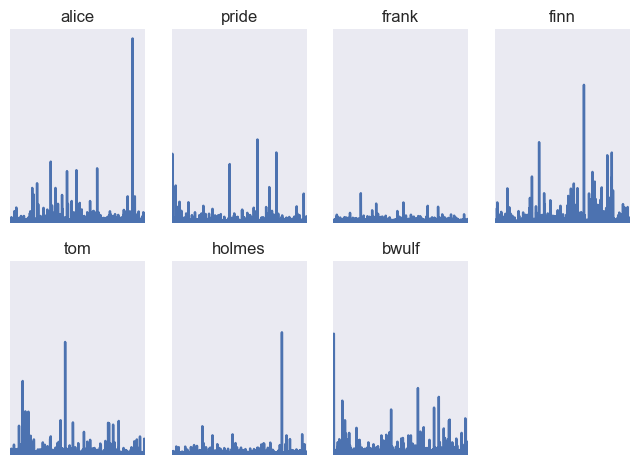

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

x = np.arange(len(all_words)) + 1
books = list(counts.keys())

for i in range(tfidf.shape[0]):
    book_tfidf = tfidf[i]
    
    plt.subplot(2, 4, i + 1)
    plt.plot(x, book_tfidf)
    plt.title(books[i])
    plt.ylim([0, 0.12])
    plt.xlim([0, x.shape[0] + 1])
    plt.xticks([])
    plt.yticks([])

One final bit of introspective magic: the above histograms are great, but they don't really give us a good intuition for what's really going on in these books.

Ever seen a word cloud before?

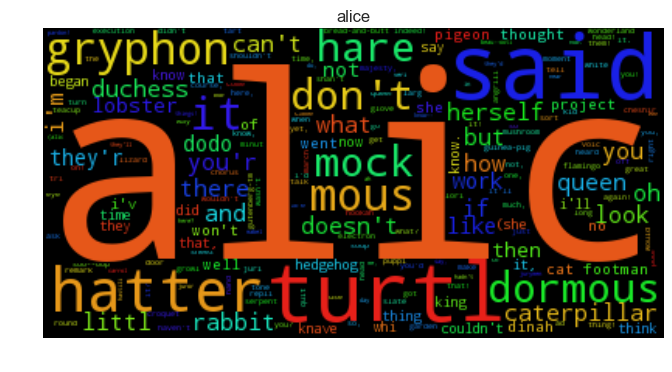

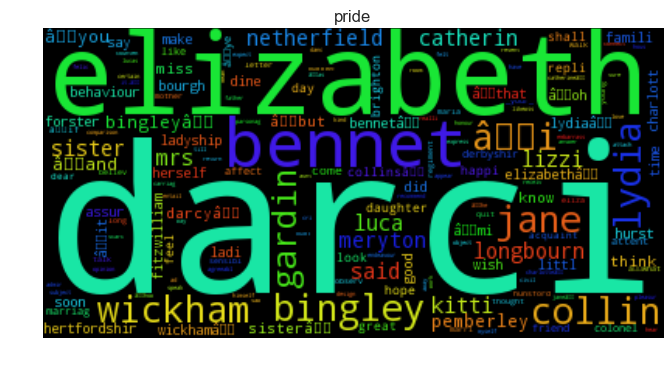

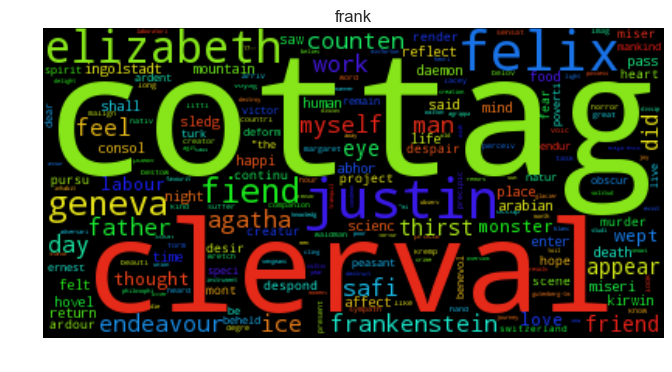

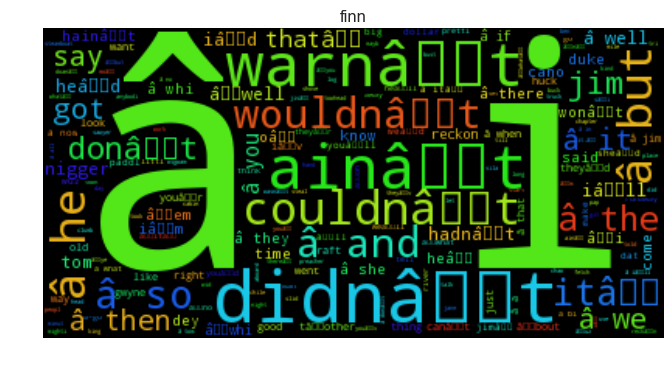

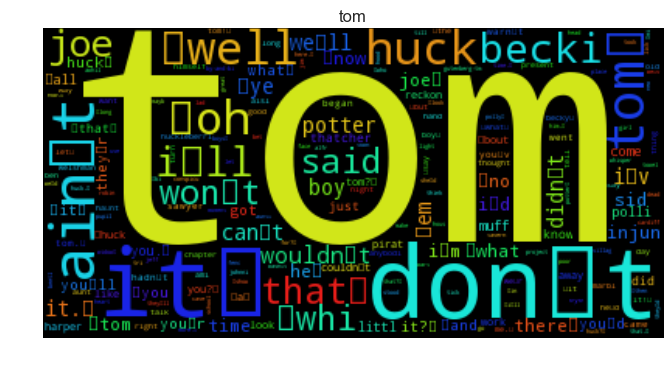

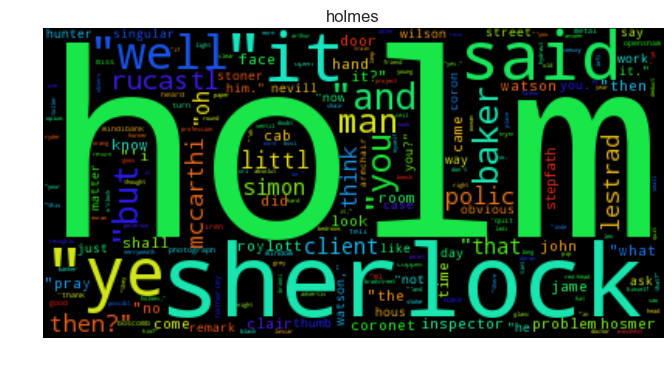

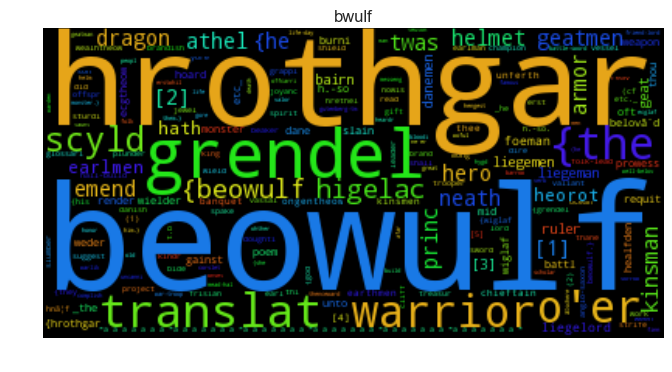

In [26]:
from wordcloud import WordCloud

for i in range(tfidf.shape[0]):
    book_tfidf = tfidf[i]
    freqs = []
    for j, word in enumerate(all_words):
        if book_tfidf[j] > 0:
            freqs.append((word, book_tfidf[j]))
    wc = WordCloud().generate_from_frequencies(freqs)

    #plt.subplot(4, 2, i + 1)
    plt.figure(i)
    plt.imshow(wc)
    plt.title(books[i])
    plt.axis("off")

# Review Questions

Some questions to discuss and consider:

1: There are many machine learning algorithms that rely on the probability of a single word, $P(w)$, under some condition (e.g. the probability of a word in a conservative or liberal blog). Explain what this would involve.

2: So far we've considered only nonzero word counts. When you combine all the unique words in a collection of documents together, it's possible (even likely) that quite a few of the words will have counts of 0 in some of the documents. Why is this? What problems might this cause for the later analyses?

3: Another point we haven't even touched on, but which can really generate very powerful features, is the inclusion of $n$-grams. If you consider $n = 1$ to be the case of individual words as we've used them throughout the last two lectures, with $n = 2$ we instead consider a single "token" to be every sequence of 2 consecutive words. What advantages and disadvantages would this approach have (e.g. $n = 2$, or *bigrams*), over using single words ($n = 1$, or *unigrams*)?

## Course Administrivia

 - How is A8 going?

 - Flipped lecture tomorrow! Any volunteers?

 - **4th review session on Thursday!** Come with questions. Second-to-last review session of the semester!

## Additional Resources

 1. Grus, Joel. *Data Science from Scratch*, Chapter 9. 2015. ISBN-13: 978-1491901427
 2. Saha, Amit. *Doing Math with Python*, Chapter 3. 2015. ISBN-13: 978-1593276409
 3. Richert, Willi and Coelho, Luis Pedro. *Building Machine Learning Systems with Python*, Chapter 2. 2013. ISBN-13: 978-1782161400